# L10

## Bayesian Particle Tracking

Alan Zhou

For the minimum requirement of my project, I'll be analyzing the 3D trajectory data of multiple particles along with the uncertainties in their positions.

Fortunately, because the diffusion process follows the normal distribution, writing down a model is straightforward. For any given data point, the PDF for the distance a particle will travel by brownian motion is given by:

$$P(\Delta r|\theta_i) = \frac{1}{\sqrt{2\pi \sigma^2}}\exp{\frac{-(\Delta r)^2}{2\sigma^2}}$$

where the $\theta_i$ are the parameters of the model. These are $a$, radius of the particle, $\mu$, dynamic viscosity of the medium, $T$, temperature, and $\tau$, time constant. These show up in our above equation since $\sigma$ is given by $\sqrt{3D\tau}$. And from Stokes - Einstein we know:

$$D = \frac{k_bT}{6\pi\mu a}$$

where $k_b$ is Boltzmann's constant.

If we assume that the error term in the measurement of a position is Gaussian, we can see that for a given data point, we have (as in Gregory 4.51) the convolution of two gaussians:

$$p(Y_i|M,\theta,I)=\frac{1}{\sqrt{2\pi}\sqrt{\sigma_i^2+\sigma_{mi}^2}}\exp{\frac{-(y_i-m(x_i|\theta_i))^2}{2(\sigma_i^2+\sigma_{mi}^2)}}$$

where $\theta_i$ represents the parameters of the model

For n data points we have a likelihood function that is just the product of n such gaussians:

$$p(\Delta r_{1,2}, \Delta r_{2,3}, ..., \Delta r_{n-1, n}|M,\theta_i,) = \Pi_{i=1}^n p(\Delta x_{i-1,i}|\theta_i)$$

$$=(2\pi)^{-N/2}\{\Pi_{i=1}^n(\sigma_i^2+\sigma_{mi}^2)^{-1/2}\}\exp\{\sum_{i=1}^N(\frac{-(\Delta r)^2}{2(\sigma_i^2+\sigma_{mi}^2)}\}$$

As a function of the coordinate positions of each particle in the ith frame $x_i,y_i,z_i$, the likelihood function is:

$$p(D|M,\theta,I)=(2\pi)^{-N/2}\{\Pi_{i=1}^n\frac{1}{\sqrt{(\sigma_i^2+\sigma_{mi}^2)}}\}\exp\{\sum_{i=1}^N(-\frac{(x_i-x_{i-1})^2+(y_i-y_{i-1})^2+(z_i-z_{i-1})^2}{2(\sigma_i^2+\sigma_{mi}^2)}\}$$

## Analysis of Test Data:

We'll take a single particle and let it diffuse randomly for 1000 time steps of t = 1s with parameters $T = 300$, $\mu = 10^{-4}$, $a = 10^{-8}$. Our initial analysis will involve MCMC to find our 'missing' parameters.

In [4]:
%matplotlib inline

import Bayesian_Particle_Tracking

from Bayesian_Particle_Tracking import model
from Bayesian_Particle_Tracking.model import log_likelihood
from Bayesian_Particle_Tracking.model import log_posterior
from Bayesian_Particle_Tracking.model import log_prior
from Bayesian_Particle_Tracking import io
from Bayesian_Particle_Tracking.prior import JeffreysPrior
from Bayesian_Particle_Tracking.prior import UniformPrior
from Bayesian_Particle_Tracking.printable import Printable
from Bayesian_Particle_Tracking import generate_data
from Bayesian_Particle_Tracking.generate_data import data_generation, generator
import emcee
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [13]:
# the model has 3 parameters; we'll use 40 walkers and 1000 steps each
ndim = 3
nwalkers = 40
nsteps = 1000

# set up the walkers in a "Gaussian ball" around the least-squares estimate
# see http://dan.iel.fm/emcee/current/user/line/

starting_positions = emcee.utils.sample_ball(
    (10**(-4),300, 10**(-8)),
    (10**(-6),30,10**(-10)),nwalkers)

Creating our simulated data:

In [11]:
data = Bayesian_Particle_Tracking.generate_data.generator(1000,10**(-8),10**(-4),10**(-8),[0,0,0])
np.save('test_data', data)
#home_dir = "/Users/alanzhou/Documents/Physics_201/final_project/Bayesian-Particle-Tracking/Bayesian_Particle_Tracking/"
home_dir = "/Users/mayaanjurdietrich/GitHub/Bayesian-Particle-Tracking/Bayesian_Particle_Tracking/"
new_data = np.load(home_dir + 'test_data.npy')
input_data = io.input_data

In [14]:
# set up the sampler object
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior, 
                                args=[input_data])
# run the sampler. We use iPython's %time directive to tell us 
# how long it took (in a script, you would leffave out "%time")
%time sampler.run_mcmc(starting_positions, nsteps)
print('Done')

CPU times: user 1min 12s, sys: 399 ms, total: 1min 13s
Wall time: 1min 13s
Done


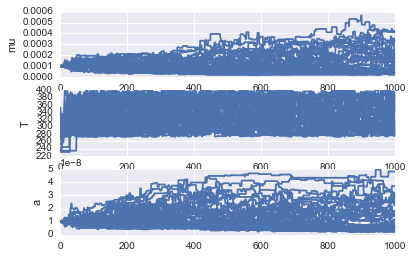

In [15]:
fig, (ax_mu, ax_T, ax_a) = plt.subplots(3)
ax_mu.set(ylabel='mu')
ax_T.set(ylabel='T')
ax_a.set(ylabel='a')
for i in range(nwalkers):
    sns.tsplot(sampler.chain[i,:,0], ax=ax_mu)
    sns.tsplot(sampler.chain[i,:,1], ax=ax_T)
    sns.tsplot(sampler.chain[i,:,2], ax=ax_a)

Our burn in time is about 200 steps, so we'll cut off our sampler at the 200th step.

In [6]:
import pandas as pd
samples = sampler.chain[:,200:,:]
# reshape the samples into a 1D array where the colums are mu, T, a
traces = samples.reshape(-1, ndim).T
# create a pandas DataFrame with labels. 
parameter_samples = pd.DataFrame({'mu': traces[0], 'T': traces[1], 'a': traces[2]})

Now we can plot the marginal probabilities for each parameter.

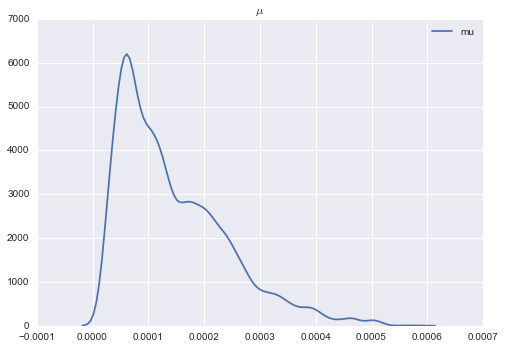

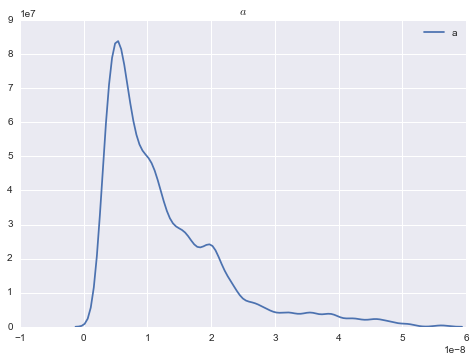

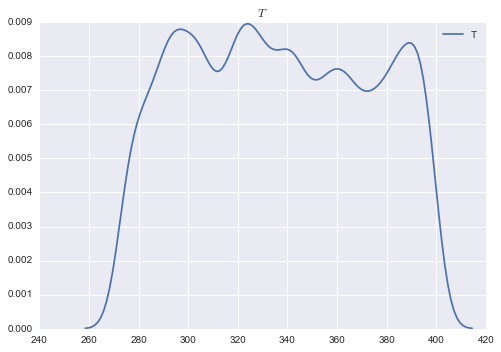

In [7]:
sns.kdeplot(parameter_samples['mu'])
plt.title('$\mu$')
plt.figure()
sns.kdeplot(parameter_samples['a'])
plt.title('$a$')
plt.figure()
sns.kdeplot(parameter_samples['T'])
plt.title('$T$')

We can also take the 68% credible interval

In [8]:
q = parameter_samples.quantile([0.16,0.50,0.84], axis=0)

In [9]:
print("T = {:.2f} + {:.2f} - {:.2f}".format(q['T'][0.50], 
                                            q['T'][0.84]-q['T'][0.50],
                                            q['T'][0.50]-q['T'][0.16]))
print("a = {:.10f} + {:.10f} - {:.10f}".format(q['a'][0.50], 
                                            q['a'][0.84]-q['a'][0.50],
                                            q['a'][0.50]-q['a'][0.16]))
print("mu = {:.5f} + {:.5f} - {:.5f}".format(q['mu'][0.50], 
                                            q['mu'][0.84]-q['mu'][0.50],
                                            q['mu'][0.50]-q['mu'][0.16]))

T = 335.16 + 45.82 - 40.46
a = 0.0000000098 + 0.0000000106 - 0.0000000050
mu = 0.00012 + 0.00012 - 0.00006


We see that our true values for a and mu lie are actually pretty close to what we originally input. 

Of course, normally we know the value of T and so we might take it as a given. In that case, we only have two parameters, $\mu$ and $a$ that we have to marginalize over.

In [10]:
from Bayesian_Particle_Tracking.model import log_likelihood2
from Bayesian_Particle_Tracking.model import log_posterior2
from Bayesian_Particle_Tracking.model import log_prior2

In [11]:
data = model.generator(1000,10**(-8),10**(-4),10**(-8),[0,0,0])
np.save('test_data', data)
home_dir = "/Users/alanzhou/Documents/Physics_201/final_project/Bayesian-Particle-Tracking/Bayesian_Particle_Tracking/"
new_data = np.load(home_dir + 'test_data.npy')
input_data = io.input_data

In [12]:
# the model has 2 parameters; we'll use 40 walkers and 1000 steps each
ndim = 2
nwalkers = 40
nsteps = 1000

# set up the walkers in a "Gaussian ball" around the least-squares estimate
# see http://dan.iel.fm/emcee/current/user/line/

starting_positions = emcee.utils.sample_ball(
    (10**(-4), 10**(-8)),
    (10**(-6), 10**(-10)),nwalkers)

# set up the sampler object
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior2, 
                                args=[input_data])
# run the sampler. We use iPython's %time directive to tell us 
# how long it took (in a script, you would leffave out "%time")
%time sampler.run_mcmc(starting_positions, nsteps)
print('Done')

CPU times: user 1min 3s, sys: 584 ms, total: 1min 3s
Wall time: 1min 6s
Done


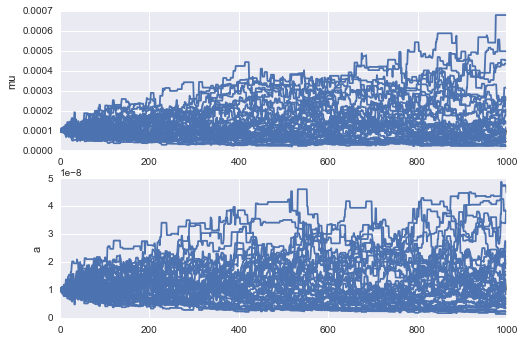

In [13]:
fig, (ax_mu, ax_a) = plt.subplots(2)
ax_mu.set(ylabel='mu')
ax_a.set(ylabel='a')
for i in range(nwalkers):
    sns.tsplot(sampler.chain[i,:,0], ax=ax_mu)
    sns.tsplot(sampler.chain[i,:,1], ax=ax_a)

In [14]:
samples = sampler.chain[:,200:,:]
# reshape the samples into a 1D array where the colums are mu, T, a
traces = samples.reshape(-1, ndim).T
# create a pandas DataFrame with labels. 
parameter_samples = pd.DataFrame({'mu': traces[0], 'a': traces[1]})

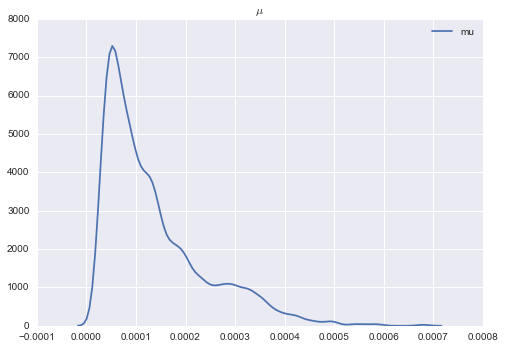

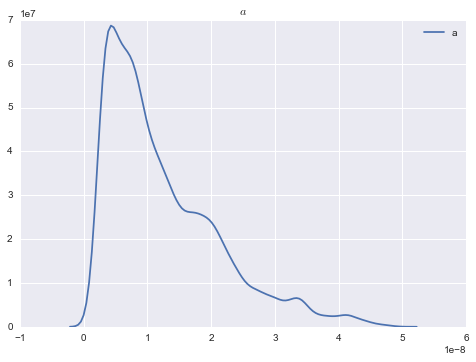

In [15]:
sns.kdeplot(parameter_samples['mu'])
plt.title('$\mu$')
plt.figure()
sns.kdeplot(parameter_samples['a'])
plt.title('$a$')

In [16]:
q = parameter_samples.quantile([0.16,0.50,0.84], axis=0)

print("a = {:.10f} + {:.10f} - {:.10f}".format(q['a'][0.50], 
                                            q['a'][0.84]-q['a'][0.50],
                                            q['a'][0.50]-q['a'][0.16]))
print("mu = {:.5f} + {:.5f} - {:.5f}".format(q['mu'][0.50], 
                                            q['mu'][0.84]-q['mu'][0.50],
                                            q['mu'][0.50]-q['mu'][0.16]))

a = 0.0000000098 + 0.0000000113 - 0.0000000056
mu = 0.00010 + 0.00014 - 0.00006


Much better, although the burn in time might not have been true.

Of course, if we have two out of three parameters known (e.g., mu and T) we can either do MCMC for just the single parameter remaining. Or we can follow the procedure in Gregory 3.8 to find $p(\theta|D,M,I)$ where $\theta$ is the Diffusion coefficient or the remaining parameter in question (since both are directly proportional to each other, finding one is the equivalent of finding the other).

Let's define our new equivalent posterior/prior/likelihood functions here to not clutter our model.py module

In [17]:
def log_prior3(theta):
    a = theta
    a_prior = JeffreysPrior(10**(-10), 10**(-6)).lnprob(a)
    if a > 0:
        return a_prior
    else:
        return -np.inf

def log_likelihood3(theta, diffusion_object, tau = 1, T = 300, mu = 10**(-4)):
    a = theta
    data = diffusion_object.data
    sigma = diffusion_object.sigma
    
    sigma = list(sigma)
    del sigma[0]
    sigma = np.array(sigma)
    
    kb = 1.38*10**(-23)
    D = (kb*T)/(6*np.pi*mu*a)
    if D <= 0:
        return -np.inf
    sigma1 = np.sqrt(3*D*tau)
    
    #Turn data into displacements instead of positions
    data = data-data[0]
    
    #This should give us the delta x_{i,i-1}. point_before is just the data list minus the last element.
    #data_points is the data list minus the first element.
    #point_before is the data list minus the last element.
    #distance is the measurement of the distance between two consecutive points in the series.

    point_before = list(data)
    del point_before[len(point_before)-1]
    point_before = np.array(point_before)
    x_before, y_before, z_before = point_before[:,0], point_before[:,1], point_before[:,2]

    data_points = list(data)
    del data_points[0]
    data_points = np.array(data_points)
    x_data, y_data, z_data = data_points[:,0], data_points[:,1], data_points[:,2]
    distance = np.sqrt((x_before-x_data)**2+(y_before-y_data)**2+(z_before-z_data)**2)

    #Should be correct with the correct log properties
    result = (-len(data)/2)*np.log(2*np.pi)+np.sum(np.log((sigma1**2+sigma**2)**(-1/2)))+(-((distance)**2)/(2*(sigma1**2+sigma**2))).sum()
    return result
    
def log_posterior3(theta, diffusion_object):
    return log_prior3(theta) + log_likelihood3(theta, diffusion_object)


In [18]:
log_likelihood3(10**(-8),input_data)

9155.7888304590924

In [19]:
# the model has 2 parameters; we'll use 40 walkers and 1000 steps each
ndim = 1
nwalkers = 40
nsteps = 1000

starting_positions = [10**(-8) + 1e-10*np.random.randn(ndim) for i in range(nwalkers)]

# set up the sampler object
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior3, 
                                args=[input_data])
# run the sampler. We use iPython's %time directive to tell us 
# how long it took (in a script, you would leffave out "%time")
%time sampler.run_mcmc(starting_positions, nsteps)
print('Done')

CPU times: user 1min 16s, sys: 1.05 s, total: 1min 17s
Wall time: 1min 24s
Done


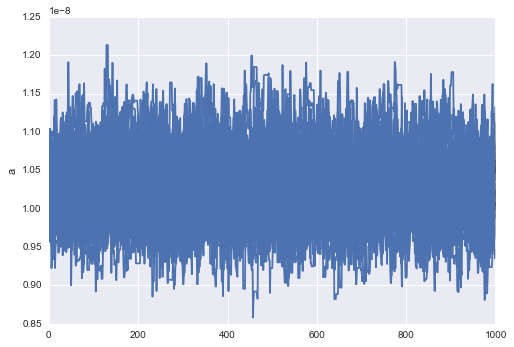

In [20]:
fig, (ax_a) = plt.subplots(1)
ax_a.set(ylabel='a')
for i in range(nwalkers):
    sns.tsplot(sampler.chain[i,:,0], ax=ax_a)

In [21]:
samples = sampler.chain[:,200:,:]
# reshape the samples into a 1D array where the colums are mu, T, a
traces = samples.reshape(-1, ndim).T
# create a pandas DataFrame with labels. 
parameter_samples = pd.DataFrame({'a': traces[0]})

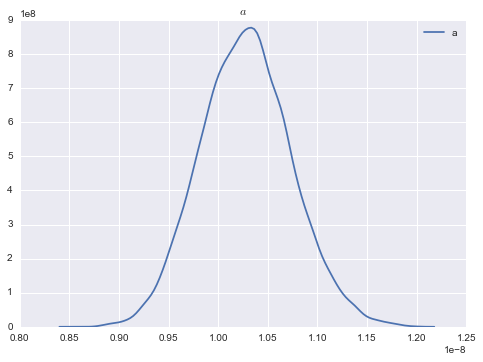

In [22]:
sns.kdeplot(parameter_samples['a'])
plt.title('$a$')

In [23]:
q = parameter_samples.quantile([0.16,0.50,0.84], axis=0)

print("a = {:.10f} + {:.10f} - {:.10f}".format(q['a'][0.50], 
                                            q['a'][0.84]-q['a'][0.50],
                                            q['a'][0.50]-q['a'][0.16]))

a = 0.0000000103 + 0.0000000005 - 0.0000000005


This is really nice, and pretty much exactly what we expected.

# Testing other stuff:

The rest of this is just random testing of stuff.

In [51]:
def likelihood3(theta, diffusion_object, tau = 1, T = 300, mu = 10**(-4)):
    a = theta
    data = diffusion_object.data
    sigma = diffusion_object.sigma
    
    sigma = list(sigma)
    del sigma[0]
    sigma = np.array(sigma)
    
    kb = 1.38*10**(-23)
    D = (kb*T)/(6*np.pi*mu*a)
    sigma1 = np.sqrt(3*D*tau)
    
    #Turn data into displacements instead of positions
    data = data-data[0]

    #This should give us the delta x_{i,i-1}. point_before is just the data list minus the last element.
    #data_points is the data list minus the first element.
    #point_before is the data list minus the last element.
    #distance is the measurement of the distance between two consecutive points in the series.

    point_before = list(data)
    del point_before[len(point_before)-1]
    point_before = np.array(point_before)
    x_before, y_before, z_before = point_before[:,0], point_before[:,1], point_before[:,2]

    data_points = list(data)
    del data_points[0]
    data_points = np.array(data_points)
    x_data, y_data, z_data = data_points[:,0], data_points[:,1], data_points[:,2]
    distance = np.sqrt((x_before-x_data)**2+(y_before-y_data)**2+(z_before-z_data)**2)

    #Should be correct with the correct log properties
    result = (2*np.pi)**(-len(data)/2)*np.prod((sigma1**2+sigma**2)**(-1/2))*np.exp((-((distance)**2)/(2*(sigma1**2+sigma**2))).sum())
    return result

x = np.linspace(10**(-9), 10**(-7), 999)
def parameter(x, diffusion_object):
    return (1/x)*likelihood3(x,diffusion_object)

[ nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
  nan  nan  

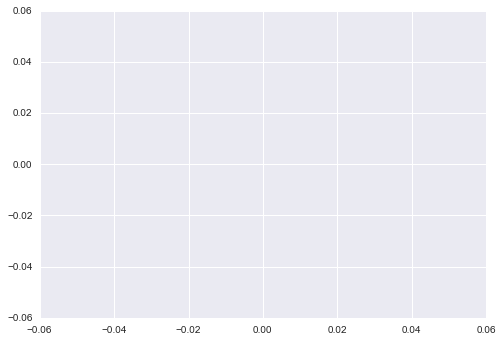

In [54]:
print(likelihood3(10**(-8), input_data))

plt.plot(x, parameter(x,input_data))